# Topic Modeling & Anxiety-Level Exploration
## Objective
Validate whether NMF-based topic modeling combined with the NRC Emotion Lexicon (anxiety) provides useful, reliable signals on our corpus.

## Step 1 — Feasibility Check
- Load posts with embedded top comments from data/raw/posts_with_comments_YYYYMMDD.jsonl.
- Build a DataFrame with post metadata and a combined text field: title + selftext + top_comments.
- Normalize text (lowercase, remove URLs, strip punctuation; optionally expand contractions and remove domain-specific stopwords).
- Create TF–IDF features and fit an NMF model to discover topics.
- Apply NRC to score anxiety and validate with human review (spot-check examples for face validity).

## Step 2 — Improve Topic Quality
- Tune vectorization (n-grams, min_df/max_df, stopword list).
- Tune NMF (n_components, initialization, regularization).
- Compare with simple baselines (e.g., LSA) and track topic coherence + human interpretability.

## Step 3 — Triage & Fixes
- Address data quality issues (duplicates, encoding, missing fields).
- Log errors and decisions; re-run as needed.

In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
from pathlib import Path
from typing import List, Dict, Any
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk
import emoji
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

In [3]:
def load_jsonl(path: Path) -> List[Dict[str, Any]]:
    rows: List[Dict[str, Any]] = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows


def to_dataframe(records: List[Dict[str, Any]]) -> pd.DataFrame:
    # Extract required fields; coerce missing keys to None
    def extract(r: Dict[str, Any]) -> Dict[str, Any]:
        top_comments = r.get("top_comments") or []
        # Keep only comment bodies for compactness
        comment_bodies = [c.get("body") for c in top_comments if isinstance(c, dict)]
        return {
            "post_id": r.get("post_id"),
            "url": r.get("url"),
            "subreddit": r.get("subreddit"),
            "created_utc": r.get("created_utc"),
            "title": r.get("title"),
            "selftext": r.get("selftext"),
            "score": r.get("score"),
            "num_comments": r.get("num_comments"),
            "upvote_ratio": r.get("upvote_ratio"),
            "over_18": r.get("over_18"),
            # Keep list of strings (comment bodies)
            "top3_comments": comment_bodies,
        }

    df = pd.DataFrame([extract(r) for r in records])
    return df

In [4]:
# ORIGINAL CODE 

# records = load_jsonl(Path("../data/raw/posts_with_comments_20250916.jsonl"))
# raw_data = to_dataframe(records)

# raw_data.to_csv("../data/processed/reddit_posts_with_comments_20250916.csv", index=False)

# raw_data.head(5)

# # generate list of distinct subreddits
# subreddits = raw_data["subreddit"].unique()
# print(subreddits)

# ORIGINAL CODE 

# ======================
# Edits below 
# ======================

records = load_jsonl(Path("../data/raw/submission.jsonl"))
raw_data = to_dataframe(records)

raw_data.to_csv("../data/processed/reddit_submission.csv", index=False)
subreddits = raw_data["subreddit"].unique()
print(subreddits)

['Anxiety' 'HealthAnxiety' 'mentalhealth' 'TrueOffMyChest' 'economy'
 'OpenAI' 'GetMotivated' 'unpopularopinion']


In [5]:
len(raw_data)

6503

### Tokenize posts

In [6]:
# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict for replacement
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
stop_words = ENGLISH_STOP_WORDS

# List of punctuation
punc = list(set(string.punctuation))

def casual_tokenizer(text):
    """Tokenizer that preserves contractions and most punctuation."""
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def expandContractions(text, c_re=c_re):
    """Expand contractions in text using c_re."""
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def emojis_to_text(text: str) -> str:
    """
    Replace emojis with descriptive words (e.g., :smiling_face:) and
    add spaces around them so tokenizers split cleanly.
    If the emoji package is unavailable, return the original text.
    """
    if emoji is None:
        return text
    try:
        return emoji.demojize(text, language="en", delimiters=(" ", " "))
    except Exception:
        return text

def process_text(text):
    """
    Preprocess the input text by tokenizing, normalizing, and removing unwanted elements.
    """
    text = emojis_to_text(text)
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text

In [7]:
df = raw_data.copy()
# combine title, selftext, and top3_comments into a single text field
df['fulltext'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('') + ' ' + df['top3_comments'].fillna('').apply(lambda comments: ' '.join(comments) if isinstance(comments, list) else '')
# process the full text
df['processed_full_text'] = df['fulltext'].apply(process_text)
df.head()

,post_id,url,subreddit,created_utc,title,selftext,score,num_comments,upvote_ratio,over_18,top3_comments,fulltext,processed_full_text
0,1nkes7e,None,Anxiety,1.758217e+09,Terrified of my symptoms,So I just got over a nasty cold but the cough ...,1,0,1.0,False,[],Terrified of my symptoms So I just got over a ...,"[terrifi, symptom, just, got, nasti, cold, cou..."
1,1nkes09,None,Anxiety,1.758217e+09,Does anyone else here have chronic tinnitus?,This crap is driving me insane.\n\nI’ve been a...,1,0,1.0,False,[],Does anyone else here have chronic tinnitus? T...,"[doe, anyon, els, chronic, tinnitus, crap, dri..."
2,1njtn2a,None,Anxiety,1.758154e+09,I can't sleep anymore,"Hey everyone, I've been diagnosed with anxiety...",1,1,1.0,False,[],"I can't sleep anymore Hey everyone, I've been ...","[sleep, anymor, hey, everyon, diagnos, anxieti..."
3,1nke28u,None,Anxiety,1.758215e+09,Losing hope,Ive had health anxiety for 2 minths now. Ever ...,1,0,1.0,False,[],Losing hope Ive had health anxiety for 2 minth...,"[lose, hope, ive, health, anxieti, minth, sinc..."
4,1nke23t,None,Anxiety,1.758215e+09,Can someone give me a logical explanation as t...,I'm dizzy all the time and lately my heart fee...,1,2,1.0,False,[],Can someone give me a logical explanation as t...,"[someon, logic, explan, whi, feel, way, convin..."


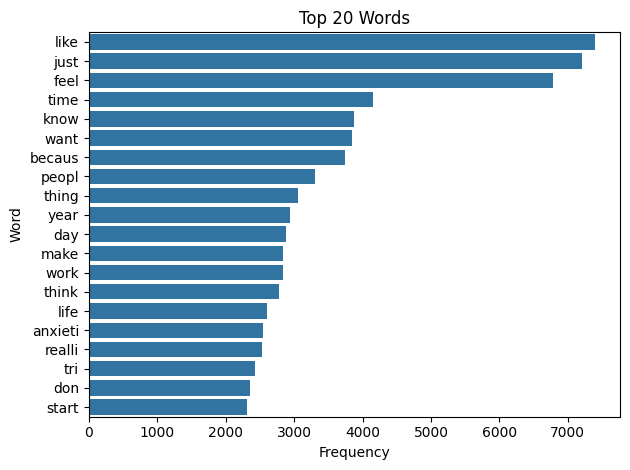

In [8]:
def plot_top20_words():
    words = [w.lower() for row in df['processed_full_text'].dropna() for w in row]
    top = Counter(words).most_common(20)
    words, counts = zip(*top) if top else ([], [])
    sns.barplot(x=list(counts), y=list(words))
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.title('Top 20 Words')
    plt.tight_layout()
    
    plt.show()

plot_top20_words()

We may need to extend the list of stop words to avoid meaningless words such as case, ai, type, use...

In [9]:

texts = df['processed_full_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Run the nmf model
nmf = NMF(
    n_components=10,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha_W=0.0,
    tol=1e-4,
    random_state=42
)

doc_topic = nmf.fit_transform(tfidf)
topic_word = nmf.components_

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
top_words_idx = np.argsort(topic_word, axis=1)[:, ::-1][:, :10]
top_words = [feature_names[idx].tolist() for idx in top_words_idx]
topic_labels = [" ".join(words[:5]) for words in top_words]

top_topic = np.argmax(doc_topic, axis=1)
top_score = doc_topic[np.arange(doc_topic.shape[0]), top_topic]
assignments = pd.DataFrame({
    "topic": top_topic,
    "score": top_score,
    "label": [topic_labels[t] for t in top_topic],
}, index=df.index)


assignments_renamed = assignments.rename(
    columns={"topic": "nmf_topic", "score": "nmf_score", "label": "nmf_label"}
)
df = df.join(assignments_renamed[["nmf_topic", "nmf_score", "nmf_label"]])

df.head()


,post_id,url,subreddit,created_utc,title,selftext,score,num_comments,upvote_ratio,over_18,top3_comments,fulltext,processed_full_text,nmf_topic,nmf_score,nmf_label
0,1nkes7e,None,Anxiety,1.758217e+09,Terrified of my symptoms,So I just got over a nasty cold but the cough ...,1,0,1.0,False,[],Terrified of my symptoms So I just got over a ...,"[terrifi, symptom, just, got, nasti, cold, cou...",3,0.037669,anxieti health attack panic health anxieti
1,1nkes09,None,Anxiety,1.758217e+09,Does anyone else here have chronic tinnitus?,This crap is driving me insane.\n\nI’ve been a...,1,0,1.0,False,[],Does anyone else here have chronic tinnitus? T...,"[doe, anyon, els, chronic, tinnitus, crap, dri...",3,0.074016,anxieti health attack panic health anxieti
2,1njtn2a,None,Anxiety,1.758154e+09,I can't sleep anymore,"Hey everyone, I've been diagnosed with anxiety...",1,1,1.0,False,[],"I can't sleep anymore Hey everyone, I've been ...","[sleep, anymor, hey, everyon, diagnos, anxieti...",3,0.060272,anxieti health attack panic health anxieti
3,1nke28u,None,Anxiety,1.758215e+09,Losing hope,Ive had health anxiety for 2 minths now. Ever ...,1,0,1.0,False,[],Losing hope Ive had health anxiety for 2 minth...,"[lose, hope, ive, health, anxieti, minth, sinc...",3,0.069729,anxieti health attack panic health anxieti
4,1nke23t,None,Anxiety,1.758215e+09,Can someone give me a logical explanation as t...,I'm dizzy all the time and lately my heart fee...,1,2,1.0,False,[],Can someone give me a logical explanation as t...,"[someon, logic, explan, whi, feel, way, convin...",5,0.056779,feel like feel like just don


Need to work on NMF model to improve the accuracy of nmf_label.

# Maria Edits

### Workflow & Results

**Process**: Auto-generate stopwords → Vectorize with TF-IDF → Fit NMF → Score anxiety with NRC → Evaluate quality

**Key Results**:
- **6 topics** discovered with good coherence (NPMI: 0.4)
- **91.7%** of posts have confident topic assignments
- **Anxiety scores** range 0.13-0.99 (well-distributed)
- **Topics** include: personal stories, health/medical, work/economy, motivation, support groups

**Output**: DataFrame with `nmf_topic`, `nmf_label`, `nmf_conf`, `anxiety_score` columns


### 1. Imports & Configuration

**Purpose**: Initialize required libraries, set reproducible seeds, define final TF-IDF/NMF hyperparameters, and optionally specify the NRC lexicon path for emotion features.
```python

In [100]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.stem import PorterStemmer
import json, joblib, os


# Best settings: 10 topics, 10000 features, 0.4 max_df, 12 min_df -> score of .547
RANDOM_STATE = 0
FINAL_K = 10

FINAL_VEC = dict(
    ngram_range=(1,2), 
    min_df=12,     
    max_df=0.4,        
    max_features=10000,
    stop_words='english'
)
FINAL_NMF = dict(solver="mu", beta_loss="kullback-leibler", alpha_W=0.0, alpha_H=0.1, l1_ratio=0.7,
                 max_iter=1500, tol=1e-4, random_state=RANDOM_STATE)

NRC_PATH = "../data/raw/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"


### 2. Data Loading & Tokenization

**Purpose**: Load a DataFrame (from memory or `data.csv`), select the text column, and convert each document into a lowercase token list for downstream processing.
```python

In [101]:
if "df" not in globals():
    if os.path.exists("data.csv"):
        df = pd.read_csv("data.csv")
    else:
        raise RuntimeError("No DataFrame `df` in memory and 'data.csv' not found. "
                           "Create `df` with a text column (e.g., 'processed_full_text' or 'text').")

# pick a text column
CANDIDATE_TEXT_COLS = ["processed_full_text", "cleaned_text", "fulltext", "selftext", "text"]
TEXT_COL = next((c for c in CANDIDATE_TEXT_COLS if c in df.columns), None)
if TEXT_COL is None:
    raise RuntimeError(f"Could not find a text column in df. Looked for: {CANDIDATE_TEXT_COLS}")

def ensure_tokens(x):
    """Coerce item into list[str]. Uses whitespace split if a string; otherwise empty list."""
    if isinstance(x, list):  return [str(t) for t in x]
    if isinstance(x, str):   return x.lower().split()
    return []

texts_tokens = [ensure_tokens(v) for v in df[TEXT_COL].fillna("")]


### 3. Helper Functions

**Purpose**: Provide lightweight utilities for topic-model diagnostics and labeling—lift-based top terms, mean inter-topic cosine, assignment purity, NPMI coherence, and concise label generation.
```python

In [102]:
def identity(x): return x

def top_terms_by_lift(H, X, vocab, topn=12):
    tf = np.asarray(X.sum(axis=0)).ravel() + 1e-12
    lift = H / tf
    order = np.argsort(lift, axis=1)[:, ::-1]
    return [[vocab[j] for j in row[:topn]] for row in order], order

def mean_topic_cosine(H):
    Hn = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-12)
    cos = Hn @ Hn.T
    np.fill_diagonal(cos, 0.0)
    return float(cos.mean())

def assignment_purity(W, thresh=0.40):
    P = W / (W.sum(axis=1, keepdims=True) + 1e-12)
    return float((P.max(axis=1) >= thresh).mean()), P

def coherence_npmi(topics, docs, min_co=1, eps=1e-12):
    """Positive ~[0,1], higher is better. Simple, dependency-free NPMI."""
    N = len(docs)
    doc_sets = [set(d) for d in docs]
    DF = Counter()
    for s in doc_sets:
        for w in s: DF[w] += 1
    def D(w):  return DF.get(w, 0)
    def D12(a,b):
        c=0
        for s in doc_sets:
            if a in s and b in s: c+=1
        return c
    scores=[]
    for words in topics:
        pairs=[]
        for i in range(1,len(words)):
            for j in range(i):
                wi,wj = words[i], words[j]
                d12 = D12(wi,wj)
                if d12 < min_co: continue
                p12 = d12 / N
                p1  = D(wj) / N
                p2  = D(wi) / N
                pmi  = np.log((p12+eps)/(p1*p2+eps))
                npmi = pmi / (-np.log(p12+eps))
                pairs.append(npmi)
        if pairs: scores.append(float(np.mean(pairs)))
    return float(np.mean(scores)) if scores else float("nan")

def make_label(words, n=3, max_len=28):
    s = " / ".join(words[:n])
    return s[:max_len]
    

### 4. Baseline Stoplist Construction

**Purpose**: Fit a quick TF-IDF+NMF baseline to auto-identify ubiquitous, low-salience terms (via lift and topic overlap) and merge them with domain stopwords to form a unified stoplist (`STOP_ALL`).
```python

In [103]:
vec0 = TfidfVectorizer(
    tokenizer=identity, preprocessor=identity, token_pattern=None, lowercase=False,
    stop_words=None, ngram_range=(1,2), min_df=10, max_df=0.6, max_features=20000,
    sublinear_tf=True, norm="l2"
)
X0 = vec0.fit_transform(texts_tokens)
voc0 = np.array(vec0.get_feature_names_out())

nmf0 = NMF(n_components=FINAL_K, init="nndsvda",
           solver="mu", beta_loss="kullback-leibler",
           alpha_W=0.0, alpha_H=0.0, l1_ratio=0.0,
           max_iter=800, tol=1e-4, random_state=RANDOM_STATE).fit(X0)

top0, ord0 = top_terms_by_lift(nmf0.components_, X0, voc0, topn=12)
# words that appear in >= half of topics' top lists
cnt = Counter(w for lst in top0 for w in lst)
auto_thresh = int(np.ceil(FINAL_K / 2))
AUTO_STOP = {w for w, c in cnt.items() if c >= auto_thresh}

# domain stopwords
DOMAIN_STOP = {
    "gpt","chatgpt","codex","claude","openai","anthropic","llm","ai",
    "work","time","user","people","person","post","new","need","way","model","code",
    "someth","peopl","whi","becaus","tri","actual",
    "like", "just", "realli", "didn", "ll", "weren"
}
STOP_ALL = set(AUTO_STOP) | DOMAIN_STOP
print("Auto-stop:", len(AUTO_STOP), "Domain-stop:", len(DOMAIN_STOP), "Total-stop:", len(STOP_ALL))


Auto-stop: 0 Domain-stop: 31 Total-stop: 31


### 4. Baseline Stoplist Construction

**Purpose**: Fit a quick TF-IDF+NMF baseline to auto-identify ubiquitous, low-salience terms (via lift and topic overlap) and merge them with domain stopwords to form a unified stoplist (`STOP_ALL`).

In [104]:
vec_final = TfidfVectorizer(
    tokenizer=identity, preprocessor=identity, token_pattern=None, lowercase=False,
    stop_words=list(STOP_ALL),
    ngram_range=FINAL_VEC["ngram_range"],
    min_df=FINAL_VEC["min_df"], max_df=FINAL_VEC["max_df"], max_features=FINAL_VEC["max_features"],
    sublinear_tf=True, norm="l2"
)
Xf = vec_final.fit_transform(texts_tokens)
vocab_f = np.array(vec_final.get_feature_names_out())

nmf_final = NMF(
    n_components=FINAL_K, init="nndsvda",
    **FINAL_NMF
).fit(Xf)

# Topic words (by LIFT)
top_terms_f, order_f = top_terms_by_lift(nmf_final.components_, Xf, vocab_f, topn=12)
for i, ws in enumerate(top_terms_f):
    print(f"Topic {i}: {', '.join(ws)}")

# Metrics
mean_cos = mean_topic_cosine(nmf_final.components_)
Wf = nmf_final.transform(Xf)
purity, P = assignment_purity(Wf, thresh=0.40)
npmi = coherence_npmi([ws[:10] for ws in top_terms_f], texts_tokens, min_co=1)

print("\n=== Final metrics ===")
print("NPMI coherence:", round(npmi, 3))
print("mean topic cosine:", round(mean_cos, 3))
print("assignment purity:", round(purity, 3))


/Users/mariamckay/code/umich/milestone2/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


Topic 0: thrill, pleasant, flew, say loud, yea, butt, skinni, inappropri, small talk, game play, church, park lot
Topic 1: liber, bold, optimist, em, ice cream, king, victori, mountain, gratitud, necess, embrac, banana
Topic 2: day anxieti, bad panic, hyper awar, hour sleep, ecg, attack day, anxieti heart, went doctor, heart pound, extrem anxious, anxieti want, doctor said
Topic 3: sayin, photo abov, analyt, ft, institut, metric, citizen, portfolio, yield, africa, negoti, politician
Topic 4: usernam, pleas read, use app, refin, embed, mod, calendar, spam, dm, pleas share, help pleas, pleas let
Topic 5: mutual friend, friend start, away home, got togeth, school friend, onlin friend, date year, want chest, year relationship, away year, parent alway, said know
Topic 6: hypothet, feel human, movi tv, invent, curios, radio, musician, hear thought, infinit, dialogu, portray, fellow
Topic 7: focus health, follow rule, block ani, regard health, come play, posit thought, ex emot, veterinari, pr

### 5. Labels & Document Assignments

**Purpose**: Create human-readable topic labels and attach per-document topic index, confidence, and label; then summarize topic prevalence.
```python

In [105]:
labels_f = [make_label(ws) for ws in top_terms_f]
df["nmf_topic"] = P.argmax(axis=1)
df["nmf_conf"]  = P.max(axis=1)
df["nmf_label"] = df["nmf_topic"].map(dict(enumerate(labels_f)))

topic_counts = (pd.Series(df["nmf_label"])
                  .value_counts()
                  .rename_axis("topic")
                  .reset_index(name="count"))
print("\nTopic counts:\n", topic_counts.head(10))



Topic counts:
                           topic  count
0  mutual friend / friend start    972
1   sayin / photo abov / analyt    917
2  day anxieti / bad panic / hy    851
3  hypothet / feel human / movi    635
4  scroll social / sprint / ve     634
5  focus health / follow rule /    595
6  interfac / ani sens / use ca    571
7       liber / bold / optimist    524
8  usernam / pleas read / use a    436
9      thrill / pleasant / flew    368


### 6. NRC-Based Anxiety Scoring (0–1)

**Purpose**: Load the NRC Emotion Lexicon, build a stem-aware emotion map, and compute a length-robust anxiety score per document using windowed negation and intensity cues.
```python

In [106]:
from nltk.stem import PorterStemmer

def load_nrc_lexicon(path="data/raw/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"):
    """
    Load NRC Emotion Lexicon from 'long' format (word, emotion, association)
    or 'wide' CSV with emotion columns. Returns DataFrame [word, emotion].
    """
    # ---- Try long format first ----
    try:
        nrc = pd.read_csv(
            path, sep=r"[\t,]", engine="python", header=None,
            names=["word", "emotion", "association"]
        )
        if {"word","emotion","association"}.issubset(nrc.columns):
            nrc = nrc[nrc["association"].astype(int) == 1][["word","emotion"]]
            nrc["word"] = nrc["word"].str.lower()
            return nrc
    except Exception:
        pass

    # ---- Fallback: wide format ----
    nrc = pd.read_csv(path)
    if "word" not in nrc.columns:
        nrc = nrc.rename(columns={nrc.columns[0]: "word"})
    nrc = nrc.set_index("word")

    EMOS = {"anger","anticipation","disgust","fear","joy","sadness","surprise","trust"}
    long_rows = []
    for emo in nrc.columns:
        if emo.lower() in EMOS:
            rows = nrc.index[nrc[emo] == 1]
            long_rows.extend([(w, emo) for w in rows])

    nrc_long = pd.DataFrame(long_rows, columns=["word","emotion"])
    nrc_long["word"] = nrc_long["word"].str.lower()
    return nrc_long

# -------- build stem-aware lexicon --------
NRC_PATH = "../data/raw/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
nrc_long = load_nrc_lexicon(NRC_PATH)

ps = PorterStemmer()
nrc_long["stem"] = nrc_long["word"].map(ps.stem)
LEX_STEM = nrc_long.groupby("stem")["emotion"].apply(set).to_dict()

NEGATORS  = {"not","no","never","without","hardly","barely"}
INTENSIFY = {"very","extremely","super","really"}
DIMINISH  = {"slightly","somewhat","kinda","barely"}

EMO_W = {
    "fear": 1.0, "anger": 0.6, "sadness": 0.6, "disgust": 0.3,
    "anticipation": 0.2,
    "trust": -0.3, "joy": -0.6, "surprise": 0.1
}

def anxiety_raw(tokens):
    if not isinstance(tokens, list):
        tokens = ensure_tokens(tokens)
    s = 0.0; hits = 0
    for i, w in enumerate(tokens):
        stem = ps.stem(w.lower())
        emos = LEX_STEM.get(stem, ())
        if not emos:
            continue
        window = tokens[max(0, i-3):i]
        mult = 1.0
        if any(u.lower() in NEGATORS for u in window):  mult *= -0.7
        if any(u.lower() in INTENSIFY for u in window): mult *= 1.4
        if any(u.lower() in DIMINISH  for u in window):  mult *= 0.7
        for e in emos:
            s += mult * EMO_W.get(e, 0.0)
        hits += 1
    if hits == 0:
        return 0.0
    return s / (hits**0.5)


### 8. Save Artifacts for Reuse

**Purpose**: Persist the trained vectorizer, NMF model, topic labels, and annotated dataset to disk for downstream analysis and reproducible pipelines.
```python

In [107]:
# =========================
# 7) Save artifacts for reuse
# # =========================
# joblib.dump(vec_final, "vec_final.joblib")
# joblib.dump(nmf_final, "nmf_final.joblib")
# with open("topic_labels.json", "w") as f:
#     json.dump(labels_f, f, indent=2)
# df.to_csv("posts_with_topics_and_anxiety.csv", index=False)

# print("\nSaved: vec_final.joblib, nmf_final.joblib, topic_labels.json, posts_with_topics_and_anxiety.csv")

### Word Cloud Visualization
**Purpose**: Create visual word clouds to explore vocabulary patterns across all text, anxiety levels, and topics.


In [108]:
def _pick_tokens_df(df):
    # choose a text column if tokens list is missing
    for c in ["processed_full_text","cleaned_text","fulltext","selftext","text","title"]:
        if c in df.columns: return c
    raise RuntimeError("No suitable text column found.")


In [109]:
# 1) Get tokens
try:
    tokens_list = texts_tokens
except NameError:
    # Build tokens from a text column if needed
    CANDIDATE_TEXT_COLS = ["processed_full_text","cleaned_text","fulltext","selftext","text","title"]
    TEXT_COL = next((c for c in CANDIDATE_TEXT_COLS if c in df.columns), None)
    if TEXT_COL is None:
        raise RuntimeError(f"Need a text column in df. Looked for: {CANDIDATE_TEXT_COLS}")


# 2) Compute anxiety_raw via NRC function if needed
if "anxiety_raw" not in df.columns:
    try:
        _ = anxiety_raw  # ensure function exists
    except NameError:
        raise RuntimeError("Run the NRC scoring cell that defines `anxiety_raw` (and lexicon) first.")
    df["anxiety_raw"] = [anxiety_raw(toks) for toks in tokens_list]

# 3) Robust 0–1 scaling to create anxiety_score
if "anxiety_score" not in df.columns:
    med = float(df["anxiety_raw"].median())
    mad = float((df["anxiety_raw"] - med).abs().median()) or 1e-6
    z   = (df["anxiety_raw"] - med) / (1.4826 * mad)
    df["anxiety_score"] = 1.0 / (1.0 + np.exp(-z))

print(df["anxiety_score"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]))

# 4) Build a safe list of columns to display (only keep ones that exist)
text_cols = [c for c in ["title","selftext","fulltext","text","processed_full_text","cleaned_text"] if c in df.columns]
meta_cols = [c for c in ["nmf_label","nmf_conf","nmf_topic"] if c in df.columns]
cols_show = [c for c in (text_cols[:2] + meta_cols + ["anxiety_score"]) if c in df.columns]

# 5) Show top/bottom posts
print("\nTop 10 highest anxiety:")
display(df.sort_values("anxiety_score", ascending=False).head(10)[cols_show])

print("\nTop 10 lowest anxiety:")
display(df.sort_values("anxiety_score", ascending=True).head(10)[cols_show])

# 6) Per-topic table if topics exist
if "nmf_label" in df.columns:
    topic_table = (df.groupby("nmf_label")["anxiety_score"]
                     .agg(count="count", mean="mean", median="median")
                     .sort_values("mean", ascending=False))
    display(topic_table.head(20))
else:
    print("\nNo 'nmf_label' column found.")
    

count    6503.000000
mean        0.523207
std         0.202264
min         0.133374
5%          0.242221
25%         0.349151
50%         0.500000
75%         0.677694
95%         0.882621
max         0.995067
Name: anxiety_score, dtype: float64

Top 10 highest anxiety:


,title,selftext,nmf_label,nmf_conf,nmf_topic,anxiety_score
1328,I am just broken for no reason and fear valida...,I am scared if people validates me and my brai...,mutual friend / friend start,0.446431,5,0.995067
338,"Fear and anxiety at the limit, what to do?","Hello, anxious friends! I'm here to vent becau...",liber / bold / optimist,0.316389,1,0.990153
2348,I secretly blame my step-dad for my mom's death,Hey everyone so I've been hiding this feeling ...,mutual friend / friend start,0.575871,5,0.984593
1349,I need help🥲,I am struggling SO badly. I have struggled wit...,mutual friend / friend start,0.414617,5,0.984550
378,Anti-depressants ruined my life,"Before July of this year, I (21 F), was not a ...",day anxieti / bad panic / hy,0.632029,2,0.983739
640,"My Positive Story, Living with GAD/Anxiety/Pan...",Feel like I have to pay it forward by making a...,day anxieti / bad panic / hy,0.345779,2,0.983229
1335,I want to hurt people,I carry sm anger in myself. I daydream and fan...,mutual friend / friend start,0.894165,5,0.982434
2506,I Failed. See: COWARDICE,This is going to be very long. And as long as ...,mutual friend / friend start,0.367272,5,0.981441
2425,My therapist asked me these questions and here...,1. What is bothering me the most right now?\nR...,focus health / follow rule /,0.520852,7,0.981060
676,I need advice :(,I really go through a lot of anxiety especiall...,mutual friend / friend start,0.466768,5,0.980675



Top 10 lowest anxiety:


,title,selftext,nmf_label,nmf_conf,nmf_topic,anxiety_score
1045,The SSRI Citalopram/Celexa,"Hello,\n\nAnyone of you people out there take ...",day anxieti / bad panic / hy,0.511684,2,0.133374
1026,What tips and habits do you find most helpful ...,"As I got older, I started to really value my h...",scroll social / sprint / ve,0.461195,8,0.136429
4503,Why can chatgpt not give you lyrics to songs s...,"It'll say something like ""i understand your re...",hypothet / feel human / movi,0.459483,6,0.147669
5829,the dubai chocolate would be so much better wi...,white chocolate pairs well with pistachio and ...,scroll social / sprint / ve,0.781999,8,0.150489
1160,How do waiting times within the National Healt...,"Hi everyone, \n \nI am conducting research f...",usernam / pleas read / use a,0.486206,4,0.153371
5,"Tried GPT as a therapist, made a guided medita...",Hey everyone — curious for some honest feedbac...,usernam / pleas read / use a,0.589054,4,0.153632
4747,Share your custom instructions,Has anyone created custom instructions to opti...,interfac / ani sens / use ca,0.794058,9,0.153896
1339,Importance of Pinealxt,Better Sleep: By supporting melatonin producti...,focus health / follow rule /,0.510830,7,0.156229
4371,How to use Codex CLI’s --search feature inside...,"Hey everyone,\nI’ve been using Codex CLI and r...",interfac / ani sens / use ca,0.557707,9,0.157046
1580,Outside of journaling have you and your therap...,I'm trying to help people improve their mental...,hypothet / feel human / movi,0.418282,6,0.158158


,count,mean,median
nmf_label,,,
day anxieti / bad panic / hy,851,0.695785,0.719256
mutual friend / friend start,972,0.651163,0.667876
focus health / follow rule /,595,0.563765,0.561050
thrill / pleasant / flew,368,0.514857,0.504478
scroll social / sprint / ve,634,0.499044,0.484826
hypothet / feel human / movi,635,0.485497,0.450660
usernam / pleas read / use a,436,0.453122,0.432214
sayin / photo abov / analyt,917,0.424931,0.388692
interfac / ani sens / use ca,571,0.404278,0.377752


Creating word cloud for all processed text...


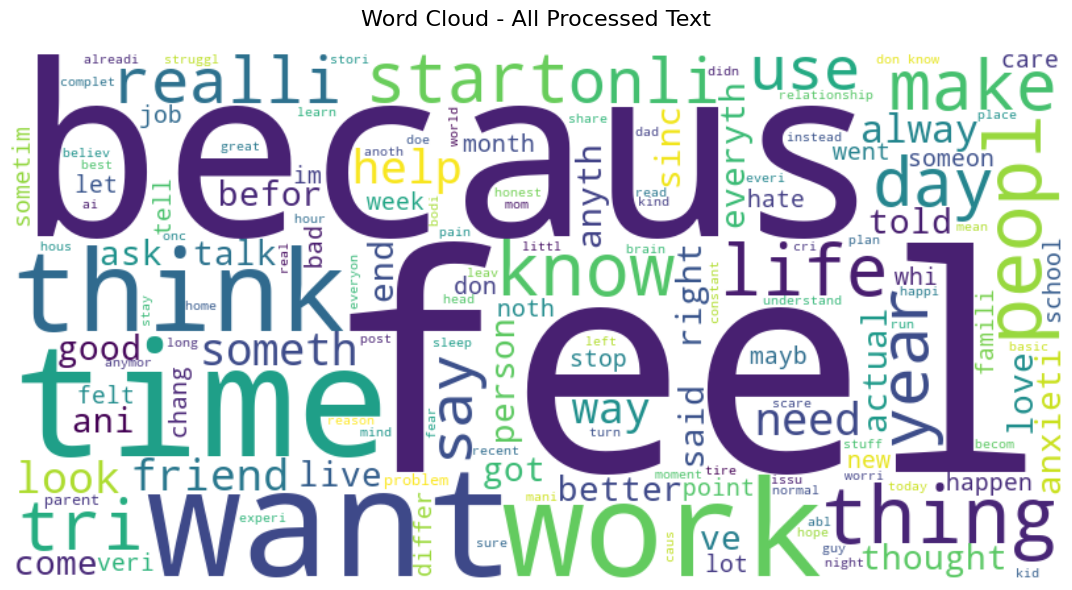

In [110]:
# Word Cloud Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Install wordcloud if not already installed
try:
    from wordcloud import WordCloud
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud

# Create word cloud from processed text
def create_word_cloud(texts, title="Word Cloud", max_words=100, width=800, height=400):
    """Create a word cloud from a list of tokenized texts"""
    # Flatten all tokens into a single string
    all_tokens = []
    for text in texts:
        if isinstance(text, list):
            all_tokens.extend(text)
        elif isinstance(text, str):
            all_tokens.extend(text.split())
    
    # Join tokens with spaces for wordcloud
    text_string = ' '.join(all_tokens)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=width, 
        height=height, 
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        relative_scaling=0.5,
        random_state=42
    ).generate(text_string)
    
    # Display
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    return wordcloud

# Create word cloud for all processed text
print("Creating word cloud for all processed text...")
wordcloud_all = create_word_cloud(
    df['processed_full_text'].dropna(), 
    title="Word Cloud - All Processed Text",
    max_words=150
)


High anxiety posts: 1626
Low anxiety posts: 1627


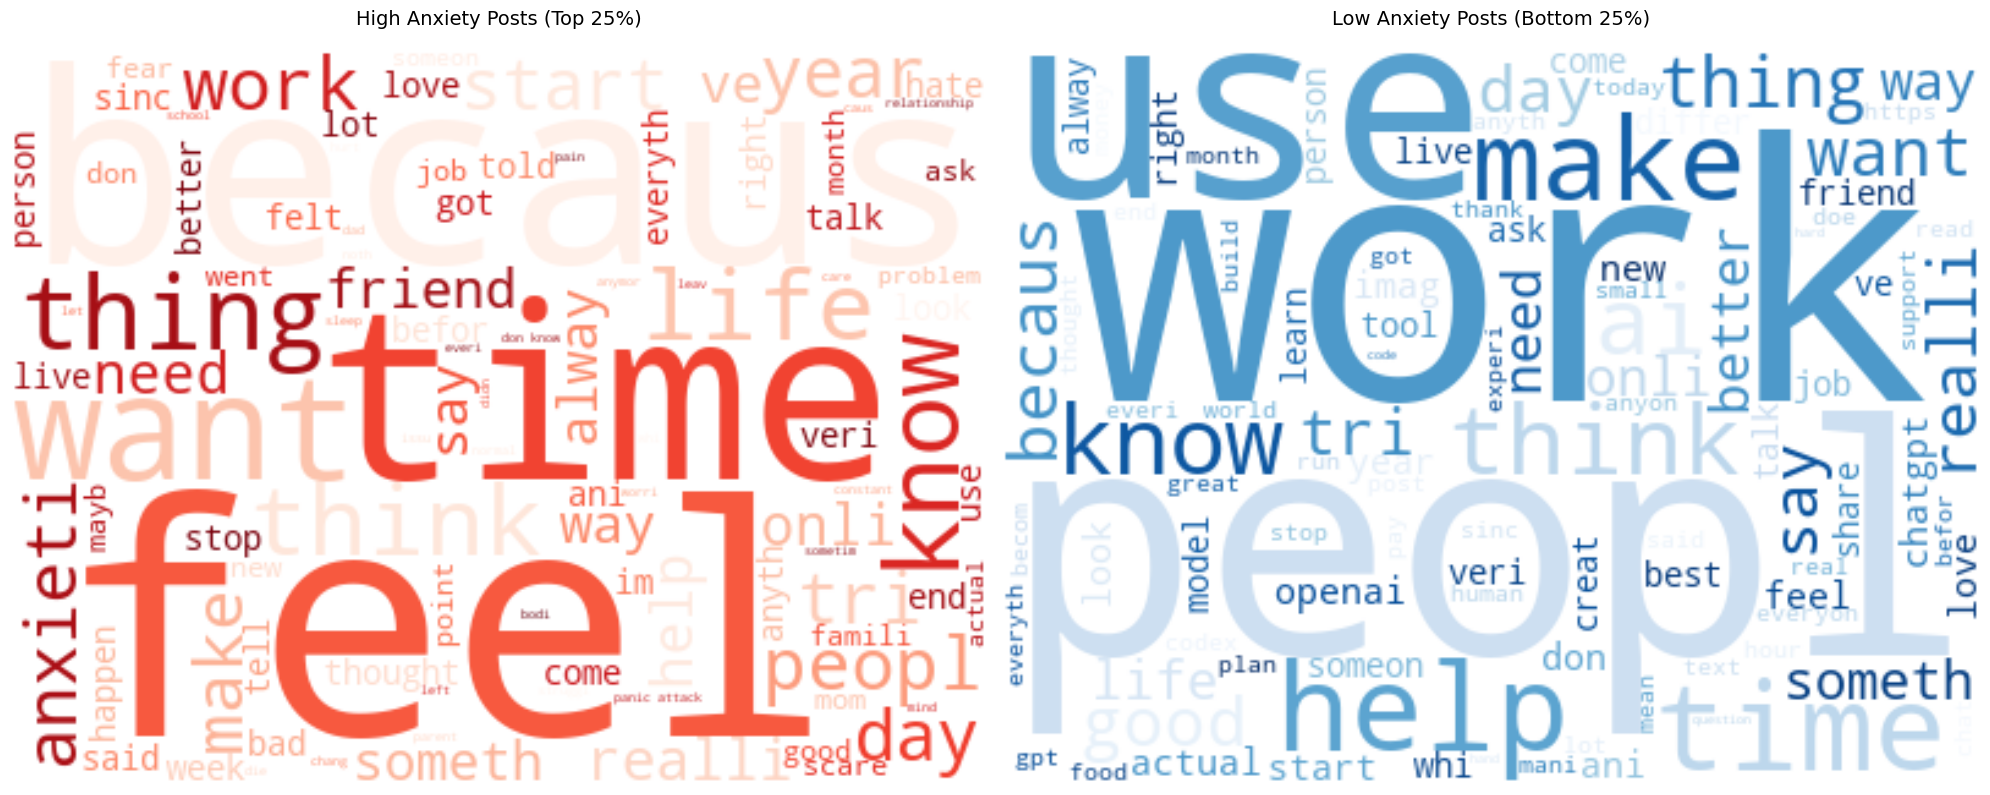


Word clouds by topic:


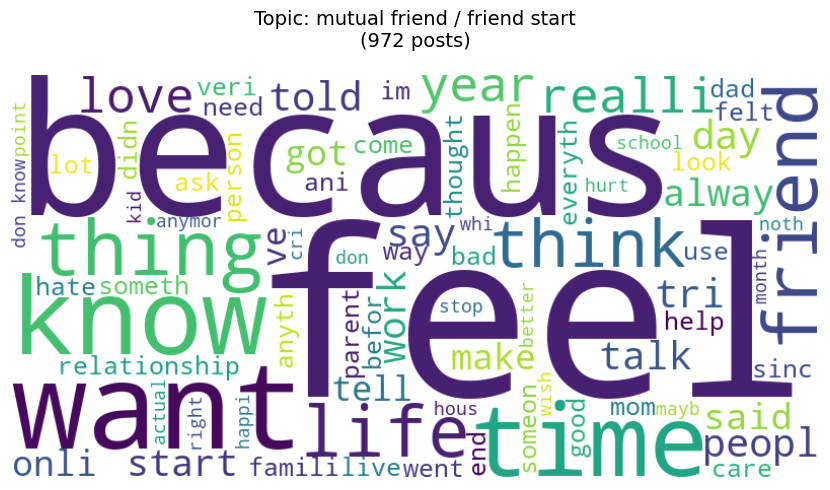

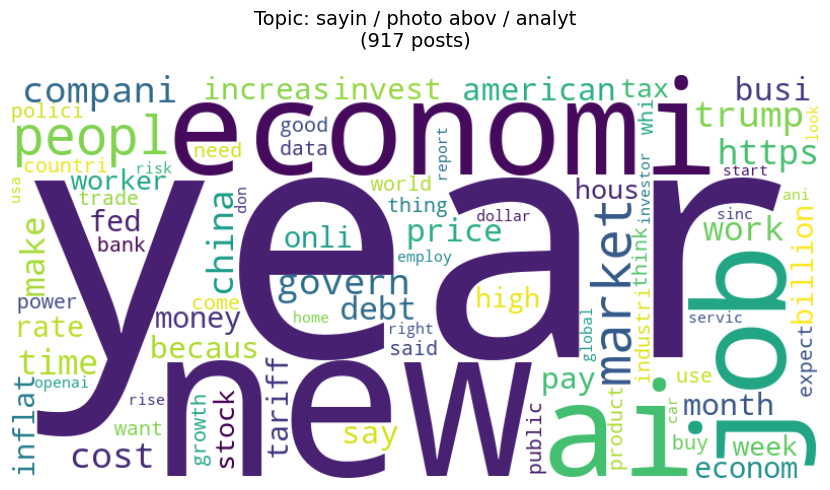

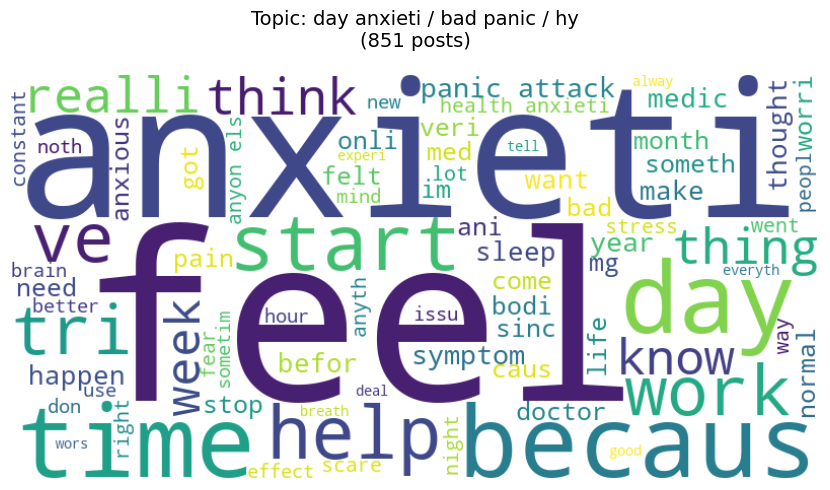

In [111]:
# Word clouds by anxiety level and topic
if 'anxiety_score' in df.columns:
    # High anxiety posts (top 25%)
    high_anxiety_threshold = df['anxiety_score'].quantile(0.75)
    high_anxiety_posts = df[df['anxiety_score'] >= high_anxiety_threshold]['processed_full_text'].dropna()
    
    # Low anxiety posts (bottom 25%)
    low_anxiety_threshold = df['anxiety_score'].quantile(0.25)
    low_anxiety_posts = df[df['anxiety_score'] <= low_anxiety_threshold]['processed_full_text'].dropna()
    
    print(f"High anxiety posts: {len(high_anxiety_posts)}")
    print(f"Low anxiety posts: {len(low_anxiety_posts)}")
    
    # Create side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # High anxiety word cloud
    if len(high_anxiety_posts) > 0:
        high_tokens = []
        for text in high_anxiety_posts:
            if isinstance(text, list):
                high_tokens.extend(text)
        high_text = ' '.join(high_tokens)
        
        wordcloud_high = WordCloud(
            width=400, height=300, background_color='white',
            max_words=100, colormap='Reds', relative_scaling=0.5,
            random_state=42
        ).generate(high_text)
        
        ax1.imshow(wordcloud_high, interpolation='bilinear')
        ax1.set_title('High Anxiety Posts (Top 25%)', fontsize=14, pad=20)
        ax1.axis('off')
    
    # Low anxiety word cloud
    if len(low_anxiety_posts) > 0:
        low_tokens = []
        for text in low_anxiety_posts:
            if isinstance(text, list):
                low_tokens.extend(text)
        low_text = ' '.join(low_tokens)
        
        wordcloud_low = WordCloud(
            width=400, height=300, background_color='white',
            max_words=100, colormap='Blues', relative_scaling=0.5,
            random_state=42
        ).generate(low_text)
        
        ax2.imshow(wordcloud_low, interpolation='bilinear')
        ax2.set_title('Low Anxiety Posts (Bottom 25%)', fontsize=14, pad=20)
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# Word clouds by topic (if topics exist)
if 'nmf_label' in df.columns:
    print("\n" + "="*50)
    print("Word clouds by topic:")
    print("="*50)
    
    # Get top 3 topics by count
    top_topics = df['nmf_label'].value_counts().head(3)
    
    for i, (topic, count) in enumerate(top_topics.items()):
        topic_posts = df[df['nmf_label'] == topic]['processed_full_text'].dropna()
        
        if len(topic_posts) > 0:
            topic_tokens = []
            for text in topic_posts:
                if isinstance(text, list):
                    topic_tokens.extend(text)
            topic_text = ' '.join(topic_tokens)
            
            plt.figure(figsize=(10, 5))
            wordcloud_topic = WordCloud(
                width=800, height=400, background_color='white',
                max_words=80, colormap='viridis', relative_scaling=0.5,
                random_state=42
            ).generate(topic_text)
            
            plt.imshow(wordcloud_topic, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Topic: {topic}\n({count} posts)', fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()
